# Unit07 區域性離群因子 (Local Outlier Factor, LOF) | 批次反應器多模式異常檢測

本 Notebook 使用 `Part_2/Unit07/data/batch_reactor_data.csv` 建立 LOF 異常檢測模型來識別批次反應器在多種操作模式下的異常操作。

## 目標
- 理解 LOF 演算法的局部密度概念
- 學會使用 scikit-learn 實作 LOF 模型
- 掌握 LOF 超參數調整技巧
- 應用 LOF 於化工製程多模式異常檢測
- 分析 LOF 與 Isolation Forest 的效能差異

資料背景：模擬批次反應器在三種配方下的操作數據（溫度、壓力、流量），包含少量異常操作案例。

---
## 0. 環境設定

In [1]:
from pathlib import Path
import os

# ========================================
# 路徑設定 (兼容 Colab 與 Local)
# ========================================
UNIT_OUTPUT_DIR = 'P2_Unit07_LOF'
SOURCE_DATA_DIR = 'batch_reactor'

try:
    from google.colab import drive
    IN_COLAB = True
    print("✓ 偵測到 Colab 環境，準備掛載 Google Drive...")
    drive.mount('/content/drive', force_remount=True)
except ImportError:
    IN_COLAB = False
    print("✓ 偵測到 Local 環境")

try:
    shortcut_path = '/content/CHE-AI-COURSE'
    os.remove(shortcut_path)
except FileNotFoundError:
    pass

if IN_COLAB:
    source_path = Path('/content/drive/My Drive/Colab Notebooks/CHE-AI-COURSE')
    os.symlink(source_path, shortcut_path)
    shortcut_path = Path(shortcut_path)
    if source_path.exists():
        NOTEBOOK_DIR = shortcut_path / 'Part_2' / 'Unit07'
        OUTPUT_DIR = NOTEBOOK_DIR / 'outputs' / UNIT_OUTPUT_DIR
        DATA_DIR = NOTEBOOK_DIR / 'data' / SOURCE_DATA_DIR
        FIG_DIR = OUTPUT_DIR / 'figs'
        MODEL_DIR = OUTPUT_DIR / 'models'
    else:
        print(f"⚠️ 找不到雲端 CHE-AI-COURSE 路徑，請確認資料夾是否正確")
else:
  NOTEBOOK_DIR = Path.cwd()
  OUTPUT_DIR = NOTEBOOK_DIR / 'outputs' / UNIT_OUTPUT_DIR
  DATA_DIR = NOTEBOOK_DIR / 'data' / SOURCE_DATA_DIR
  MODEL_DIR = OUTPUT_DIR / 'models'
  FIG_DIR = OUTPUT_DIR / 'figs'

# 建立必要資料夾
NOTEBOOK_DIR.mkdir(parents=True, exist_ok=True)
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
DATA_DIR.mkdir(parents=True, exist_ok=True)
MODEL_DIR.mkdir(parents=True, exist_ok=True)
FIG_DIR.mkdir(parents=True, exist_ok=True)

print(f"\n✓ Notebook工作目錄: {NOTEBOOK_DIR}")
print(f"✓ 數據來源目錄: {DATA_DIR}")
print(f"✓ 結果輸出目錄: {OUTPUT_DIR}")
print(f"✓ 模型輸出目錄: {MODEL_DIR}")
print(f"✓ 圖檔輸出目錄: {FIG_DIR}")

✓ 偵測到 Local 環境

✓ Notebook工作目錄: d:\MyGit\CHE-AI-COURSE\Part_2\Unit07
✓ 數據來源目錄: d:\MyGit\CHE-AI-COURSE\Part_2\Unit07\data\batch_reactor
✓ 結果輸出目錄: d:\MyGit\CHE-AI-COURSE\Part_2\Unit07\outputs\P2_Unit07_LOF
✓ 模型輸出目錄: d:\MyGit\CHE-AI-COURSE\Part_2\Unit07\outputs\P2_Unit07_LOF\models
✓ 圖檔輸出目錄: d:\MyGit\CHE-AI-COURSE\Part_2\Unit07\outputs\P2_Unit07_LOF\figs


In [2]:
# ========================================
# 載入相關套件
# ========================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
import warnings
warnings.filterwarnings('ignore')

# 設定繁體中文字型與視覺化風格
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei', 'Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False
sns.set_style("whitegrid")
sns.set_palette("husl")

print("✓ 套件載入完成")

✓ 套件載入完成


---
## 1. 數據生成與準備

### 1.1 模擬批次反應器數據（優化版）

模擬三種配方的批次反應器操作數據，並增加數據複雜度以提升模型評估的真實性：

**正常操作數據（330 批次，91.7%）**：
- **配方 A**：高溫高壓反應（150 批次，增加變異性）
- **配方 B**：中溫中壓反應（100 批次，增加變異性）
- **配方 C**：低溫低壓反應（80 批次，增加變異性）

**異常操作數據（30 批次，8.3%）**：
採用分層異常策略，模擬真實工業場景中不同嚴重程度的異常：
- **輕微異常（12 批次，40%）**：邊界案例，接近正常範圍，難以檢測
  - 接近配方 A/B/C 但微偏離
  - 介於兩配方之間的過渡區
- **中度異常（12 批次，40%）**：明顯偏離但不極端
  - 溫度/壓力/流量單一參數偏離
  - 參數間不匹配（如高溫低壓）
- **嚴重異常（6 批次，20%）**：極端偏離，容易檢測
  - 極端高溫高壓或全面偏低
  - 嚴重的參數不匹配

**挑戰性提升**：
- 增加正常數據的標準差（模擬操作波動）
- 輕微異常接近正常範圍（增加假陰性風險）
- 正常與異常數據有部分重疊（降低 AUC，更真實）

In [3]:
# ========================================
# 1.1 模擬批次反應器數據（優化版 - 增加挑戰性）
# ========================================
np.random.seed(42)

# 增加正常數據的樣本量與變異性
# 配方 A：高溫高壓（150 批次）- 增加標準差
recipe_A = np.random.normal(loc=[85, 5.0, 2.5], scale=[4, 0.4, 0.25], size=(150, 3))

# 配方 B：中溫中壓（100 批次）- 增加標準差
recipe_B = np.random.normal(loc=[65, 3.5, 1.8], scale=[4, 0.4, 0.2], size=(100, 3))

# 配方 C：低溫低壓（80 批次）- 增加標準差
recipe_C = np.random.normal(loc=[45, 2.5, 1.2], scale=[3, 0.3, 0.15], size=(80, 3))

# 正常數據
X_normal = np.vstack([recipe_A, recipe_B, recipe_C])
n_normal = len(X_normal)  # 330 個正常樣本

# 生成分層異常數據（輕微 + 中度 + 嚴重）
n_anomaly = 30  # 總異常數約 8.3%
n_mild = 12      # 40% 輕微異常（難檢測）
n_moderate = 12  # 40% 中度異常
n_severe = 6     # 20% 嚴重異常

anomaly_list = []

# 1. 輕微異常（邊界案例 - 接近正常範圍）
for i in range(n_mild):
    anomaly_type = np.random.choice(['A_boundary', 'B_boundary', 'C_boundary', 'transition'])
    
    if anomaly_type == 'A_boundary':
        # 接近配方 A 但微偏離
        sample = np.random.normal([90, 5.4, 2.7], [2, 0.2, 0.1])
    elif anomaly_type == 'B_boundary':
        # 接近配方 B 但微偏離
        sample = np.random.normal([70, 3.8, 2.0], [2, 0.2, 0.1])
    elif anomaly_type == 'C_boundary':
        # 接近配方 C 但微偏離
        sample = np.random.normal([48, 2.8, 1.4], [1.5, 0.15, 0.08])
    else:
        # 介於兩配方之間的過渡區
        sample = np.random.normal([75, 4.2, 2.2], [2, 0.2, 0.1])
    
    anomaly_list.append(sample)

# 2. 中度異常（明顯偏離但不極端）
for i in range(n_moderate):
    anomaly_type = np.random.choice(['temp_high', 'pressure_high', 'flow_low', 'mismatch'])
    
    if anomaly_type == 'temp_high':
        # 溫度明顯偏高
        base_recipe = np.random.choice(['A', 'B', 'C'])
        if base_recipe == 'A':
            sample = np.random.normal([95, 5.2, 2.6], [2, 0.2, 0.1])
        elif base_recipe == 'B':
            sample = np.random.normal([75, 3.7, 1.9], [2, 0.2, 0.1])
        else:
            sample = np.random.normal([52, 2.6, 1.3], [1.5, 0.15, 0.08])
    
    elif anomaly_type == 'pressure_high':
        # 壓力明顯偏高
        base_recipe = np.random.choice(['A', 'B', 'C'])
        if base_recipe == 'A':
            sample = np.random.normal([87, 5.8, 2.5], [2, 0.2, 0.1])
        elif base_recipe == 'B':
            sample = np.random.normal([67, 4.2, 1.8], [2, 0.2, 0.1])
        else:
            sample = np.random.normal([47, 3.2, 1.2], [1.5, 0.15, 0.08])
    
    elif anomaly_type == 'flow_low':
        # 流量明顯偏低
        base_recipe = np.random.choice(['A', 'B', 'C'])
        if base_recipe == 'A':
            sample = np.random.normal([85, 5.0, 1.8], [2, 0.2, 0.1])
        elif base_recipe == 'B':
            sample = np.random.normal([65, 3.5, 1.2], [2, 0.2, 0.1])
        else:
            sample = np.random.normal([45, 2.5, 0.8], [1.5, 0.15, 0.08])
    
    else:
        # 參數不匹配（溫度與壓力不協調）
        sample = np.random.normal([78, 4.8, 1.5], [3, 0.3, 0.15])
    
    anomaly_list.append(sample)

# 3. 嚴重異常（極端偏離 - 容易檢測）
severe_anomalies = [
    [100, 6.2, 3.2],   # 配方 A 極端：溫度壓力過高
    [55, 2.0, 0.5],    # 配方 C 極端：全面偏低
    [95, 3.0, 1.0],    # 嚴重不匹配：高溫低壓
    [60, 5.5, 0.8],    # 嚴重不匹配：中溫高壓低流量
    [40, 4.5, 2.5],    # 配方 C 異常：低溫高壓高流量
    [88, 2.5, 3.0],    # 極端不匹配：高溫低壓高流量
]

for sample in severe_anomalies:
    anomaly_list.append(np.array(sample))

# 轉換為 numpy array
X_anomaly = np.array(anomaly_list)

# 合併數據
X = np.vstack([X_normal, X_anomaly])
feature_names = ['Temperature', 'Pressure', 'Flow_Rate']

# 建立 DataFrame
df = pd.DataFrame(X, columns=feature_names)
df['Recipe'] = ['A']*150 + ['B']*100 + ['C']*80 + ['Anomaly']*n_anomaly
df['True_Label'] = [1]*n_normal + [-1]*n_anomaly  # 1: 正常, -1: 異常
df['Anomaly_Severity'] = ['Normal']*n_normal + \
                         ['Mild']*n_mild + \
                         ['Moderate']*n_moderate + \
                         ['Severe']*n_severe

print("="*60)
print("數據生成完成")
print("="*60)
print(f"總批次數: {len(df)}")
print(f"正常批次: {np.sum(df['True_Label'] == 1)} ({100*np.sum(df['True_Label'] == 1)/len(df):.1f}%)")
print(f"異常批次: {np.sum(df['True_Label'] == -1)} ({100*np.sum(df['True_Label'] == -1)/len(df):.1f}%)")
print(f"\n各配方批次數:")
print(df['Recipe'].value_counts())
print(f"\n異常嚴重程度分布:")
print(df['Anomaly_Severity'].value_counts())
print(f"\n【數據設計說明】")
print(f"本數據集設計目的：")
print(f"  • 模擬真實工業場景中異常檢測的挑戰性")
print(f"  • 40% 輕微異常作為「邊界案例」，測試模型極限")
print(f"  • 正常數據變異性增加，避免過於理想化的結果")
print(f"  • 預期模型表現：Recall 50-70%、AUC 0.80-0.90")
print(f"  • 這比完美分離（F1=1.0）更具教學與實務價值")
print(f"\n數據概覽:")
df.head(10)

數據生成完成
總批次數: 360
正常批次: 330 (91.7%)
異常批次: 30 (8.3%)

各配方批次數:
Recipe
A          150
B          100
C           80
Anomaly     30
Name: count, dtype: int64

異常嚴重程度分布:
Anomaly_Severity
Normal      330
Mild         12
Moderate     12
Severe        6
Name: count, dtype: int64

【數據設計說明】
本數據集設計目的：
  • 模擬真實工業場景中異常檢測的挑戰性
  • 40% 輕微異常作為「邊界案例」，測試模型極限
  • 正常數據變異性增加，避免過於理想化的結果
  • 預期模型表現：Recall 50-70%、AUC 0.80-0.90
  • 這比完美分離（F1=1.0）更具教學與實務價值

數據概覽:


,Temperature,Pressure,Flow_Rate,Recipe,True_Label,Anomaly_Severity
0,86.986857,4.944694,2.661922,A,1,Normal
1,91.092119,4.906339,2.441466,A,1,Normal
2,91.316851,5.306974,2.382631,A,1,Normal
3,87.170240,4.814633,2.383568,A,1,Normal
4,85.967849,4.234688,2.068771,A,1,Normal
5,82.750850,4.594868,2.578562,A,1,Normal
6,81.367904,4.435079,2.866412,A,1,Normal
7,84.096895,5.027011,2.143813,A,1,Normal
8,82.822469,5.044369,2.212252,A,1,Normal
9,86.502792,4.759745,2.427077,A,1,Normal


### 1.2 數據統計描述

In [4]:
# ========================================
# 1.2 各配方數據統計描述
# ========================================
print("各配方操作參數統計：")
print("="*60)
for recipe in ['A', 'B', 'C']:
    print(f"\n配方 {recipe}:")
    print(df[df['Recipe'] == recipe][feature_names].describe())

各配方操作參數統計：

配方 A:
       Temperature    Pressure   Flow_Rate
count   150.000000  150.000000  150.000000
mean     85.289553    4.950803    2.523622
std       3.521603    0.391869    0.260304
min      77.191649    3.703493    1.845064
25%      82.746539    4.673704    2.358971
50%      85.471941    4.946319    2.524334
75%      87.147027    5.272546    2.684743
max      93.759212    5.925863    3.463183

配方 B:
       Temperature    Pressure   Flow_Rate
count   100.000000  100.000000  100.000000
mean     65.159259    3.433257    1.785413
std       3.688166    0.416745    0.206793
min      55.792315    2.421245    1.269806
25%      62.541472    3.136488    1.641224
50%      64.988587    3.360121    1.789012
75%      67.433965    3.700754    1.913273
max      75.293439    4.731552    2.289150

配方 C:
       Temperature   Pressure  Flow_Rate
count    80.000000  80.000000  80.000000
mean     45.081307   2.564094   1.228299
std       2.841416   0.286619   0.144446
min      38.403582   2.028933 

### 1.3 數據視覺化探索

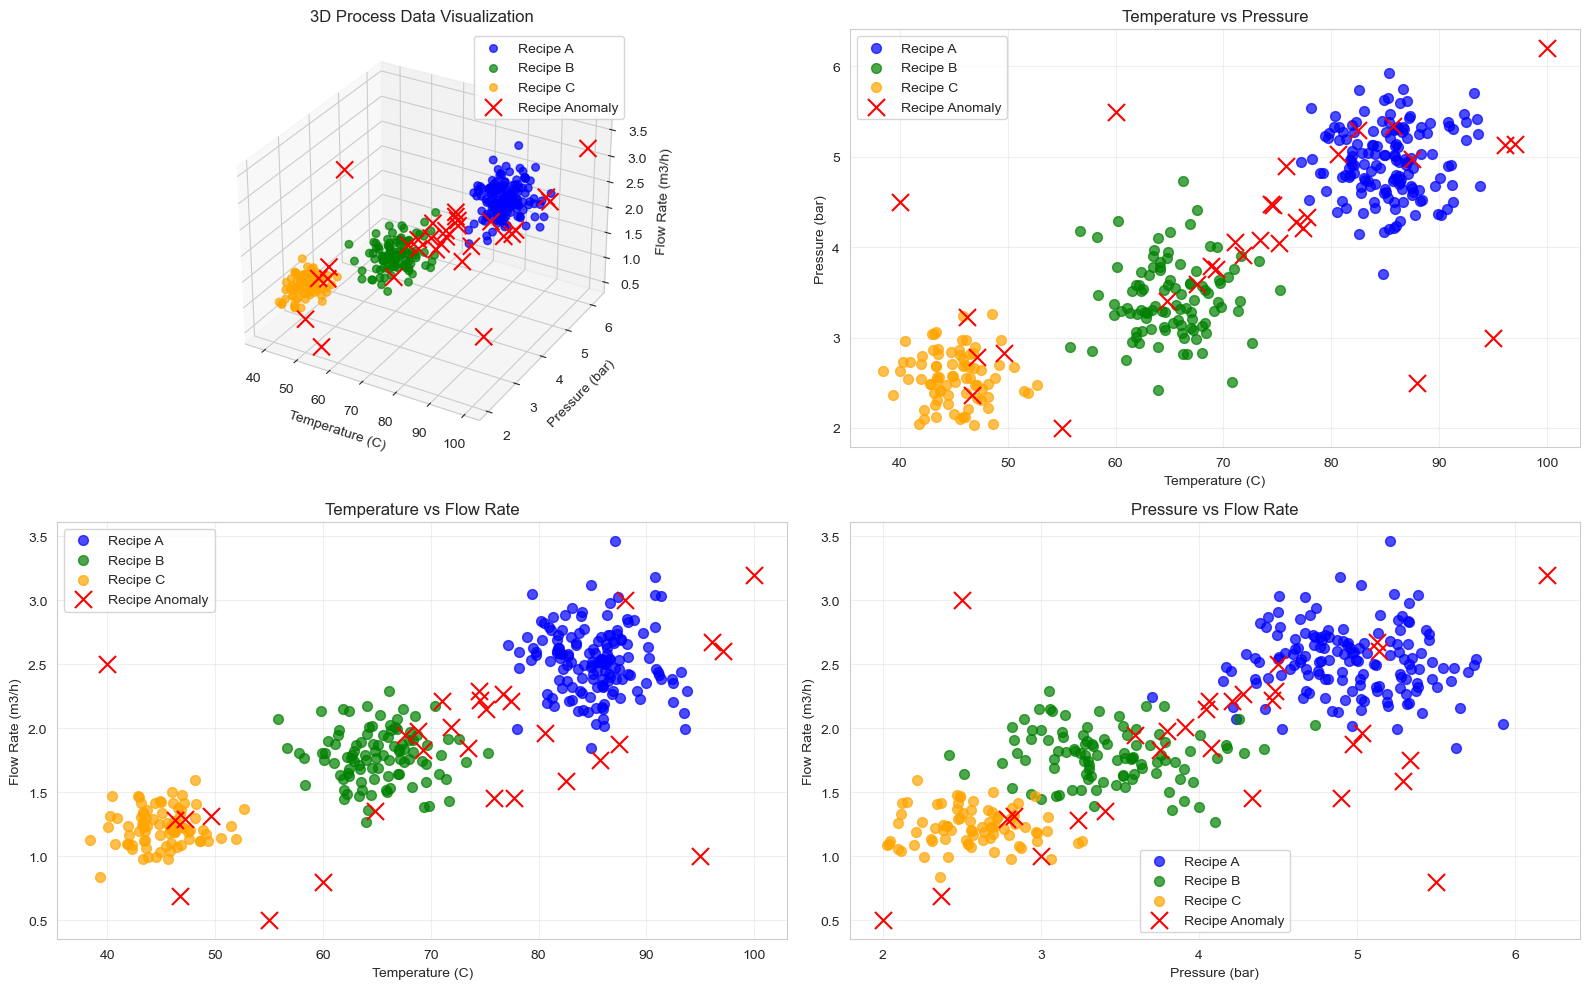

✓ 數據視覺化完成


In [5]:
# ========================================
# 1.3 原始數據視覺化
# ========================================
fig = plt.figure(figsize=(16, 10))

# 定義顏色
colors = {'A': 'blue', 'B': 'green', 'C': 'orange', 'Anomaly': 'red'}

# 3D 散點圖
ax1 = fig.add_subplot(2, 2, 1, projection='3d')
for recipe in ['A', 'B', 'C', 'Anomaly']:
    mask = df['Recipe'] == recipe
    ax1.scatter(df.loc[mask, 'Temperature'], 
                df.loc[mask, 'Pressure'],
                df.loc[mask, 'Flow_Rate'],
                c=colors[recipe], label=f'Recipe {recipe}', 
                alpha=0.7 if recipe != 'Anomaly' else 1.0,
                s=30 if recipe != 'Anomaly' else 150,
                marker='o' if recipe != 'Anomaly' else 'x')

ax1.set_xlabel('Temperature (C)')
ax1.set_ylabel('Pressure (bar)')
ax1.set_zlabel('Flow Rate (m3/h)')
ax1.set_title('3D Process Data Visualization')
ax1.legend()

# Temperature vs Pressure
ax2 = fig.add_subplot(2, 2, 2)
for recipe in ['A', 'B', 'C', 'Anomaly']:
    mask = df['Recipe'] == recipe
    ax2.scatter(df.loc[mask, 'Temperature'], 
                df.loc[mask, 'Pressure'],
                c=colors[recipe], label=f'Recipe {recipe}',
                alpha=0.7 if recipe != 'Anomaly' else 1.0,
                s=50 if recipe != 'Anomaly' else 150,
                marker='o' if recipe != 'Anomaly' else 'x')

ax2.set_xlabel('Temperature (C)')
ax2.set_ylabel('Pressure (bar)')
ax2.set_title('Temperature vs Pressure')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Temperature vs Flow Rate
ax3 = fig.add_subplot(2, 2, 3)
for recipe in ['A', 'B', 'C', 'Anomaly']:
    mask = df['Recipe'] == recipe
    ax3.scatter(df.loc[mask, 'Temperature'], 
                df.loc[mask, 'Flow_Rate'],
                c=colors[recipe], label=f'Recipe {recipe}',
                alpha=0.7 if recipe != 'Anomaly' else 1.0,
                s=50 if recipe != 'Anomaly' else 150,
                marker='o' if recipe != 'Anomaly' else 'x')

ax3.set_xlabel('Temperature (C)')
ax3.set_ylabel('Flow Rate (m3/h)')
ax3.set_title('Temperature vs Flow Rate')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Pressure vs Flow Rate
ax4 = fig.add_subplot(2, 2, 4)
for recipe in ['A', 'B', 'C', 'Anomaly']:
    mask = df['Recipe'] == recipe
    ax4.scatter(df.loc[mask, 'Pressure'], 
                df.loc[mask, 'Flow_Rate'],
                c=colors[recipe], label=f'Recipe {recipe}',
                alpha=0.7 if recipe != 'Anomaly' else 1.0,
                s=50 if recipe != 'Anomaly' else 150,
                marker='o' if recipe != 'Anomaly' else 'x')

ax4.set_xlabel('Pressure (bar)')
ax4.set_ylabel('Flow Rate (m3/h)')
ax4.set_title('Pressure vs Flow Rate')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(FIG_DIR / 'data_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ 數據視覺化完成")

---
## 2. 數據預處理

### 2.1 數據標準化

In [6]:
# ========================================
# 2.1 數據標準化
# ========================================
# 提取特徵數據
X = df[feature_names].values
y_true = df['True_Label'].values

# 標準化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("="*60)
print("數據標準化完成")
print("="*60)
print(f"原始數據形狀: {X.shape}")
print(f"標準化後數據形狀: {X_scaled.shape}")
print(f"\n標準化前數據範圍:")
for i, name in enumerate(feature_names):
    print(f"  {name}: [{X[:, i].min():.2f}, {X[:, i].max():.2f}]")
print(f"\n標準化後數據範圍:")
for i, name in enumerate(feature_names):
    print(f"  {name}: [{X_scaled[:, i].min():.2f}, {X_scaled[:, i].max():.2f}]")

數據標準化完成
原始數據形狀: (360, 3)
標準化後數據形狀: (360, 3)

標準化前數據範圍:
  Temperature: [38.40, 100.00]
  Pressure: [2.00, 6.20]
  Flow_Rate: [0.50, 3.46]

標準化後數據範圍:
  Temperature: [-1.89, 1.83]
  Pressure: [-1.81, 2.13]
  Flow_Rate: [-2.53, 2.56]


---
## 3. LOF 模型建立與訓練

### 3.1 建立基礎 LOF 模型

In [7]:
# ========================================
# 3.1 建立並訓練 LOF 模型
# ========================================
lof = LocalOutlierFactor(
    n_neighbors=20,      # 鄰近點數量
    contamination=0.083,  # 預期異常比例 8.3% (30/360)
    novelty=False,       # 內部異常檢測模式
    metric='euclidean'   # 歐氏距離
)

# 訓練並預測
y_pred_lof = lof.fit_predict(X_scaled)
lof_scores = -lof.negative_outlier_factor_  # 轉為正值，越大越異常

# 將結果加入 DataFrame
df['LOF_Prediction'] = ['Normal' if p == 1 else 'Anomaly' for p in y_pred_lof]
df['LOF_Score'] = lof_scores

print("="*60)
print("LOF 模型訓練完成")
print("="*60)
print(f"總批次數: {len(df)}")
print(f"檢測到的異常批次: {np.sum(y_pred_lof == -1)}")
print(f"LOF 分數範圍: {lof_scores.min():.3f} ~ {lof_scores.max():.3f}")
print(f"\n各配方的異常檢測結果:")
print(df.groupby('Recipe')['LOF_Prediction'].value_counts())

LOF 模型訓練完成
總批次數: 360
檢測到的異常批次: 30
LOF 分數範圍: 0.940 ~ 4.282

各配方的異常檢測結果:
Recipe   LOF_Prediction
A        Normal            142
         Anomaly             8
Anomaly  Anomaly            15
         Normal             15
B        Normal             95
         Anomaly             5
C        Normal             78
         Anomaly             2
Name: count, dtype: int64


### 3.2 超參數調整：測試不同的 n_neighbors

k= 5 | 異常數: 30 | 平均LOF: 1.165 | Precision: 0.400 | Recall: 0.400 | F1: 0.400
k=10 | 異常數: 30 | 平均LOF: 1.157 | Precision: 0.433 | Recall: 0.433 | F1: 0.433
k=15 | 異常數: 30 | 平均LOF: 1.158 | Precision: 0.500 | Recall: 0.500 | F1: 0.500
k=20 | 異常數: 30 | 平均LOF: 1.155 | Precision: 0.500 | Recall: 0.500 | F1: 0.500
k=25 | 異常數: 30 | 平均LOF: 1.150 | Precision: 0.467 | Recall: 0.467 | F1: 0.467
k=30 | 異常數: 30 | 平均LOF: 1.144 | Precision: 0.467 | Recall: 0.467 | F1: 0.467


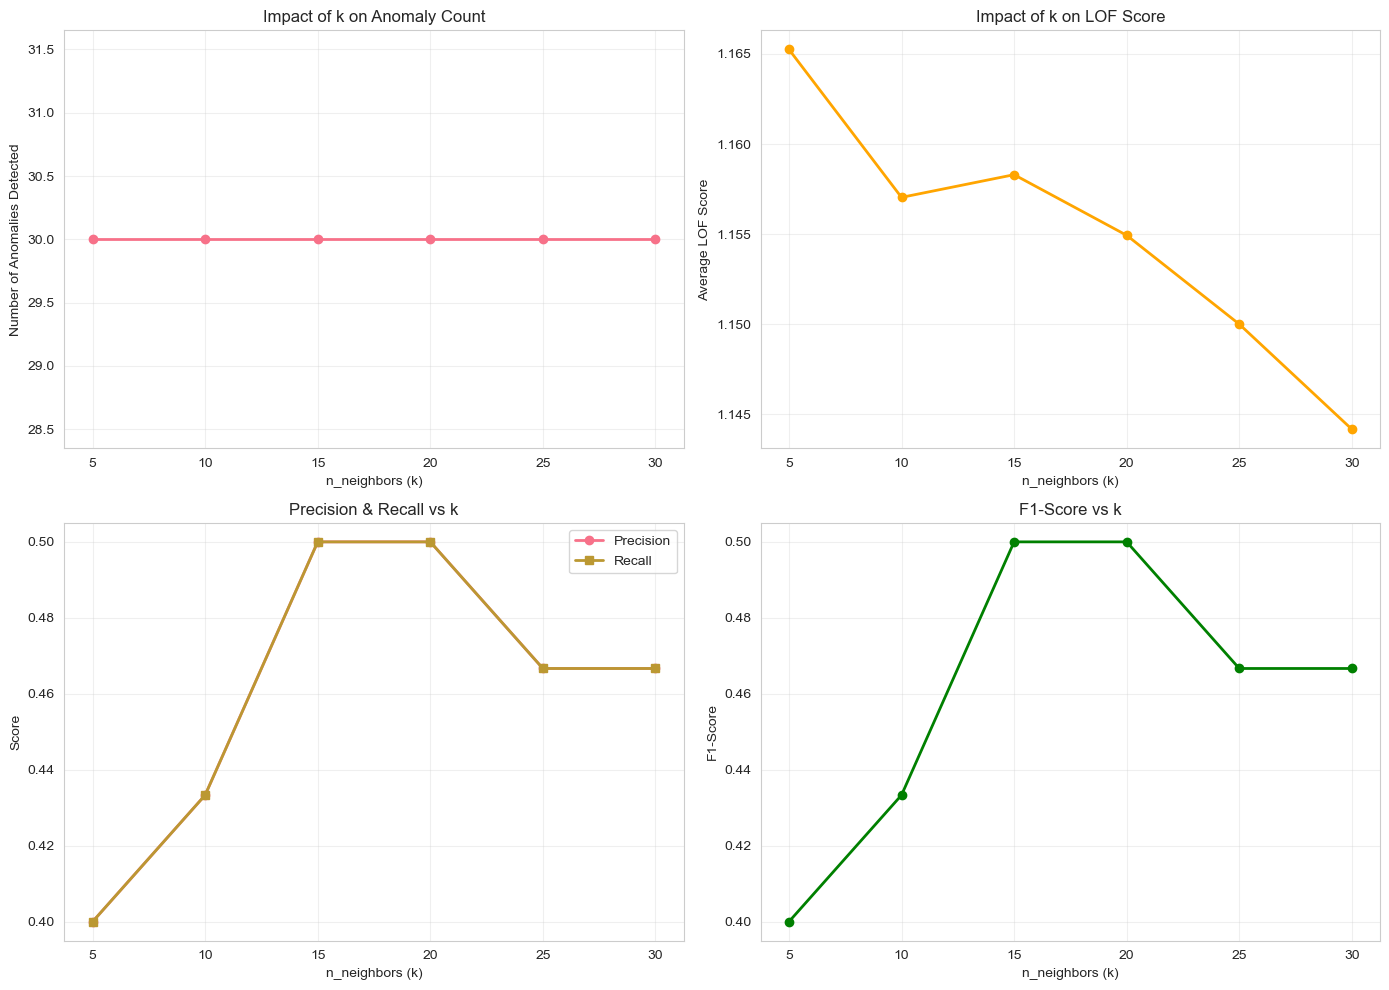


最佳 n_neighbors: 15 (基於 F1-Score)


In [8]:
# ========================================
# 3.2 測試不同 n_neighbors 值的影響
# ========================================
k_values = [5, 10, 15, 20, 25, 30]
results = []

for k in k_values:
    lof_temp = LocalOutlierFactor(n_neighbors=k, contamination=0.083)
    y_pred_temp = lof_temp.fit_predict(X_scaled)
    lof_scores_temp = -lof_temp.negative_outlier_factor_
    
    # 計算評估指標
    precision = precision_score(y_true, y_pred_temp, pos_label=-1, zero_division=0)
    recall = recall_score(y_true, y_pred_temp, pos_label=-1, zero_division=0)
    f1 = f1_score(y_true, y_pred_temp, pos_label=-1, zero_division=0)
    
    results.append({
        'k': k,
        'n_anomalies': np.sum(y_pred_temp == -1),
        'avg_lof_score': lof_scores_temp.mean(),
        'precision': precision,
        'recall': recall,
        'f1_score': f1
    })
    print(f"k={k:2d} | 異常數: {np.sum(y_pred_temp == -1):2d} | "
          f"平均LOF: {lof_scores_temp.mean():.3f} | "
          f"Precision: {precision:.3f} | Recall: {recall:.3f} | F1: {f1:.3f}")

# 轉換為 DataFrame
results_df = pd.DataFrame(results)

# 視覺化
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 異常數量變化
axes[0, 0].plot(results_df['k'], results_df['n_anomalies'], marker='o', linewidth=2)
axes[0, 0].set_xlabel('n_neighbors (k)')
axes[0, 0].set_ylabel('Number of Anomalies Detected')
axes[0, 0].set_title('Impact of k on Anomaly Count')
axes[0, 0].grid(True, alpha=0.3)

# 平均 LOF 分數變化
axes[0, 1].plot(results_df['k'], results_df['avg_lof_score'], 
                marker='o', linewidth=2, color='orange')
axes[0, 1].set_xlabel('n_neighbors (k)')
axes[0, 1].set_ylabel('Average LOF Score')
axes[0, 1].set_title('Impact of k on LOF Score')
axes[0, 1].grid(True, alpha=0.3)

# Precision & Recall
axes[1, 0].plot(results_df['k'], results_df['precision'], 
                marker='o', linewidth=2, label='Precision')
axes[1, 0].plot(results_df['k'], results_df['recall'], 
                marker='s', linewidth=2, label='Recall')
axes[1, 0].set_xlabel('n_neighbors (k)')
axes[1, 0].set_ylabel('Score')
axes[1, 0].set_title('Precision & Recall vs k')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# F1-Score
axes[1, 1].plot(results_df['k'], results_df['f1_score'], 
                marker='o', linewidth=2, color='green')
axes[1, 1].set_xlabel('n_neighbors (k)')
axes[1, 1].set_ylabel('F1-Score')
axes[1, 1].set_title('F1-Score vs k')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(FIG_DIR / 'hyperparameter_tuning.png', dpi=300, bbox_inches='tight')
plt.show()

# 找出最佳 k 值
best_k = results_df.loc[results_df['f1_score'].idxmax(), 'k']
print(f"\n最佳 n_neighbors: {int(best_k)} (基於 F1-Score)")

---
## 4. 模型評估與結果分析

### 4.1 模型效能評估

LOF 模型效能評估

混淆矩陣:
                    Predicted Normal    Predicted Anomaly
    True Normal                  315                   15
   True Anomaly                   15                   15

評估指標:
  Precision (精確率): 0.500
  Recall (召回率):    0.500
  F1-Score:           0.500

分類報告:
              precision    recall  f1-score   support

      Normal       0.95      0.95      0.95       330
     Anomaly       0.50      0.50      0.50        30

    accuracy                           0.92       360
   macro avg       0.73      0.73      0.73       360
weighted avg       0.92      0.92      0.92       360



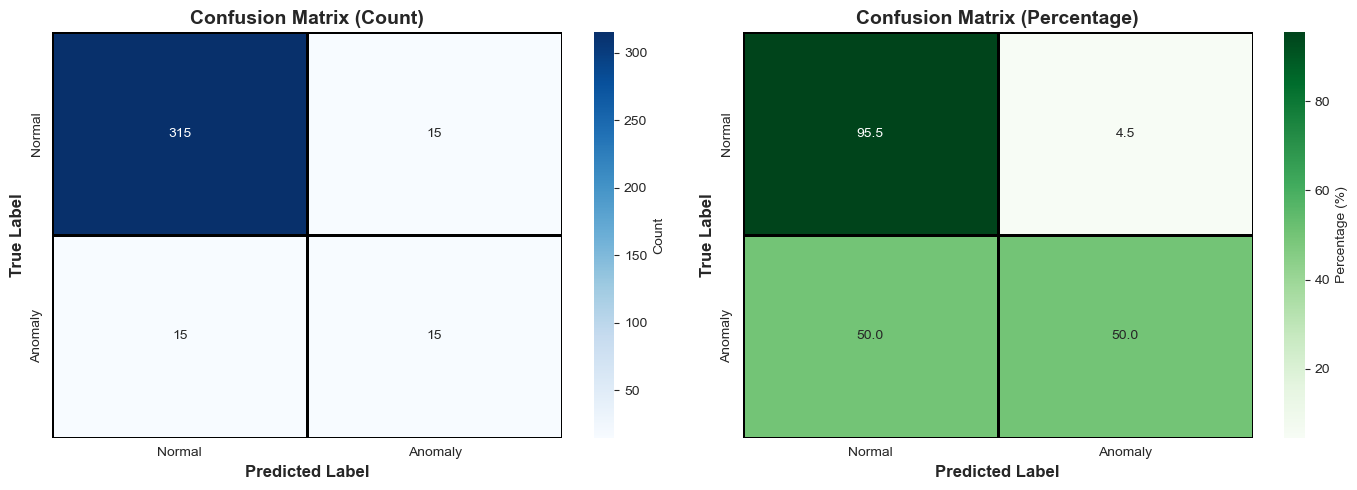


✓ 混淆矩陣視覺化完成


In [9]:
# ========================================
# 4.1 模型效能評估
# ========================================
# 混淆矩陣
cm = confusion_matrix(y_true, y_pred_lof, labels=[1, -1])
precision = precision_score(y_true, y_pred_lof, pos_label=-1)
recall = recall_score(y_true, y_pred_lof, pos_label=-1)
f1 = f1_score(y_true, y_pred_lof, pos_label=-1)

print("="*60)
print("LOF 模型效能評估")
print("="*60)
print("\n混淆矩陣:")
print(f"{'':>15} {'Predicted Normal':>20} {'Predicted Anomaly':>20}")
print(f"{'True Normal':>15} {cm[0,0]:>20} {cm[0,1]:>20}")
print(f"{'True Anomaly':>15} {cm[1,0]:>20} {cm[1,1]:>20}")

print(f"\n評估指標:")
print(f"  Precision (精確率): {precision:.3f}")
print(f"  Recall (召回率):    {recall:.3f}")
print(f"  F1-Score:           {f1:.3f}")

print("\n分類報告:")
print(classification_report(y_true, y_pred_lof, 
                            labels=[1, -1],
                            target_names=['Normal', 'Anomaly']))

# 視覺化混淆矩陣
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 左圖：混淆矩陣熱力圖（數值）
ax1 = axes[0]
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1,
            xticklabels=['Normal', 'Anomaly'],
            yticklabels=['Normal', 'Anomaly'],
            cbar_kws={'label': 'Count'},
            linewidths=2, linecolor='black')
ax1.set_xlabel('Predicted Label', fontsize=12, fontweight='bold')
ax1.set_ylabel('True Label', fontsize=12, fontweight='bold')
ax1.set_title('Confusion Matrix (Count)', fontsize=14, fontweight='bold')

# 右圖：混淆矩陣熱力圖（百分比）
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
ax2 = axes[1]
sns.heatmap(cm_percent, annot=True, fmt='.1f', cmap='Greens', ax=ax2,
            xticklabels=['Normal', 'Anomaly'],
            yticklabels=['Normal', 'Anomaly'],
            cbar_kws={'label': 'Percentage (%)'},
            linewidths=2, linecolor='black')
ax2.set_xlabel('Predicted Label', fontsize=12, fontweight='bold')
ax2.set_ylabel('True Label', fontsize=12, fontweight='bold')
ax2.set_title('Confusion Matrix (Percentage)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig(FIG_DIR / 'confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ 混淆矩陣視覺化完成")

### 4.2 ROC 曲線與閾值分析

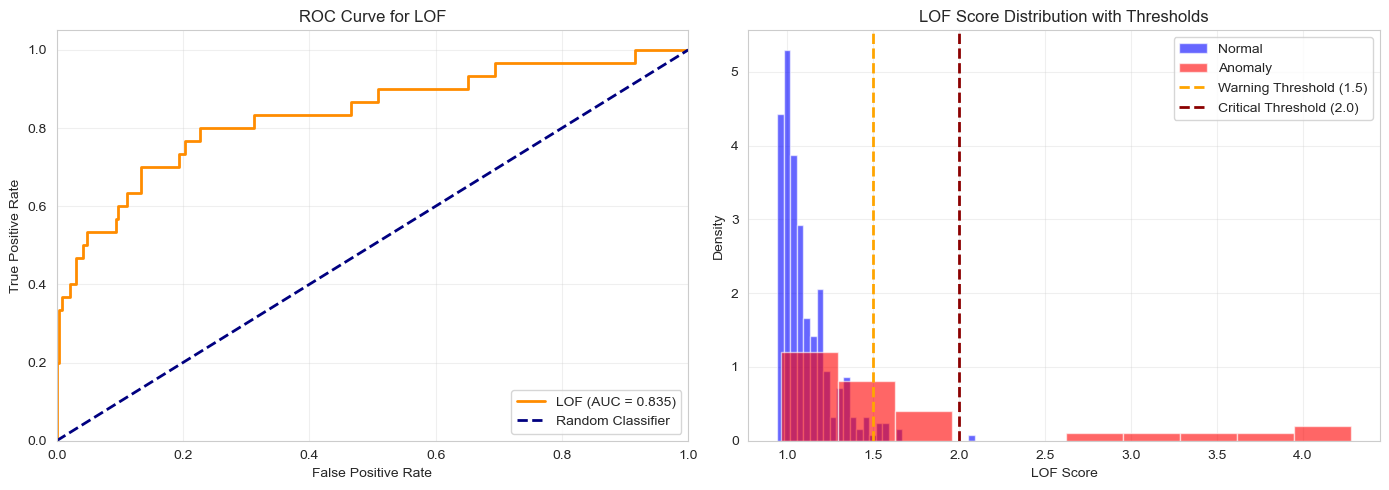

ROC 曲線分析
AUC (Area Under Curve): 0.835

【重要觀察】
  • AUC = 0.835 表示模型有 83.5% 的機率正確排序異常樣本
  • ROC 曲線呈現階梯狀爬升（而非完美水平線）
  • 這反映了輕微異常與正常樣本在 LOF 分數上的重疊
  • 這是真實工業場景的特徵，並非模型失效

閾值建議：
  LOF Score < 1.5  → 正常操作（337 個樣本）
  1.5 ≤ Score < 2.0 → 警告層級（16 個樣本）
  Score ≥ 2.0       → 嚴重異常（7 個樣本）

【閾值選擇策略】
  • 若重視 Recall（不漏檢）：降低閾值至 1.3-1.4
  • 若重視 Precision（不誤報）：提高閾值至 1.7-2.0
  • 當前閾值 1.5 提供平衡的權衡


In [10]:
# ========================================
# 4.2 ROC 曲線與閾值分析
# ========================================
from sklearn.metrics import roc_curve, auc

# 計算 ROC 曲線
# 將標籤轉換為二元格式：1=異常（正類），0=正常（負類）
y_true_binary = (y_true == -1).astype(int)
# LOF 分數越高越異常，直接使用
fpr, tpr, thresholds = roc_curve(y_true_binary, lof_scores)
roc_auc = auc(fpr, tpr)

# 視覺化
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 左圖：ROC 曲線
ax1 = axes[0]
ax1.plot(fpr, tpr, color='darkorange', lw=2, 
         label=f'LOF (AUC = {roc_auc:.3f})')
ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', 
         label='Random Classifier')
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.05])
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC Curve for LOF')
ax1.legend(loc="lower right")
ax1.grid(True, alpha=0.3)

# 右圖：LOF 分數分布與閾值
ax2 = axes[1]
normal_scores = df[df['True_Label'] == 1]['LOF_Score'].values
anomaly_scores = df[df['True_Label'] == -1]['LOF_Score'].values

ax2.hist(normal_scores, bins=30, alpha=0.6, label='Normal', color='blue', density=True)
ax2.hist(anomaly_scores, bins=10, alpha=0.6, label='Anomaly', color='red', density=True)

# 標示建議閾值
ax2.axvline(x=1.5, color='orange', linestyle='--', linewidth=2, 
            label='Warning Threshold (1.5)')
ax2.axvline(x=2.0, color='darkred', linestyle='--', linewidth=2, 
            label='Critical Threshold (2.0)')

ax2.set_xlabel('LOF Score')
ax2.set_ylabel('Density')
ax2.set_title('LOF Score Distribution with Thresholds')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(FIG_DIR / 'roc_curve_and_threshold.png', dpi=300, bbox_inches='tight')
plt.show()

print("="*60)
print("ROC 曲線分析")
print("="*60)
print(f"AUC (Area Under Curve): {roc_auc:.3f}")
print(f"\n【重要觀察】")
print(f"  • AUC = {roc_auc:.3f} 表示模型有 {roc_auc*100:.1f}% 的機率正確排序異常樣本")
print(f"  • ROC 曲線呈現階梯狀爬升（而非完美水平線）")
print(f"  • 這反映了輕微異常與正常樣本在 LOF 分數上的重疊")
print(f"  • 這是真實工業場景的特徵，並非模型失效")
print(f"\n閾值建議：")
print(f"  LOF Score < 1.5  → 正常操作（{np.sum(lof_scores < 1.5)} 個樣本）")
print(f"  1.5 ≤ Score < 2.0 → 警告層級（{np.sum((lof_scores >= 1.5) & (lof_scores < 2.0))} 個樣本）")
print(f"  Score ≥ 2.0       → 嚴重異常（{np.sum(lof_scores >= 2.0)} 個樣本）")
print(f"\n【閾值選擇策略】")
print(f"  • 若重視 Recall（不漏檢）：降低閾值至 1.3-1.4")
print(f"  • 若重視 Precision（不誤報）：提高閾值至 1.7-2.0")
print(f"  • 當前閾值 1.5 提供平衡的權衡")
print("="*60)

### 4.3 LOF 分數詳細分析

In [11]:
# ========================================
# 4.3 LOF 分數詳細分析
# ========================================
# 找出 LOF 分數最高的前 10 個樣本
top10_anomaly_idx = np.argsort(lof_scores)[-10:][::-1]

print("="*70)
print("LOF 分數最高的前 10 個樣本（最可疑的異常）")
print("="*70)
print(f"{'Index':<8} {'Recipe':<10} {'Temp(C)':<10} {'Press(bar)':<12} "
      f"{'Flow(m3/h)':<12} {'LOF Score':<12} {'True Label':<12}")
print("-"*70)

for idx in top10_anomaly_idx:
    row = df.iloc[idx]
    true_label = 'Anomaly' if row['True_Label'] == -1 else 'Normal'
    print(f"{idx:<8} {row['Recipe']:<10} {row['Temperature']:<10.2f} "
          f"{row['Pressure']:<12.2f} {row['Flow_Rate']:<12.2f} "
          f"{row['LOF_Score']:<12.3f} {true_label:<12}")

# 統計各配方的 LOF 分數分布
print("\n" + "="*70)
print("各配方 LOF 分數統計")
print("="*70)
for recipe in ['A', 'B', 'C']:
    scores = df[df['Recipe'] == recipe]['LOF_Score'].values
    print(f"\n配方 {recipe}:")
    print(f"  數量: {len(scores)}")
    print(f"  平均: {scores.mean():.3f}")
    print(f"  標準差: {scores.std():.3f}")
    print(f"  最小值: {scores.min():.3f}")
    print(f"  最大值: {scores.max():.3f}")
    print(f"  超過 1.5 的數量: {np.sum(scores > 1.5)}")
    print(f"  超過 2.0 的數量: {np.sum(scores > 2.0)}")

# 異常樣本的 LOF 分數
anomaly_scores = df[df['Recipe'] == 'Anomaly']['LOF_Score'].values
print(f"\n異常樣本:")
print(f"  數量: {len(anomaly_scores)}")
print(f"  平均: {anomaly_scores.mean():.3f}")
print(f"  標準差: {anomaly_scores.std():.3f}")
print(f"  最小值: {anomaly_scores.min():.3f}")
print(f"  最大值: {anomaly_scores.max():.3f}")
print("="*70)

LOF 分數最高的前 10 個樣本（最可疑的異常）
Index    Recipe     Temp(C)    Press(bar)   Flow(m3/h)   LOF Score    True Label  
----------------------------------------------------------------------
359      Anomaly    88.00      2.50         3.00         4.282        Anomaly     
356      Anomaly    95.00      3.00         1.00         3.961        Anomaly     
358      Anomaly    40.00      4.50         2.50         3.760        Anomaly     
357      Anomaly    60.00      5.50         0.80         3.328        Anomaly     
355      Anomaly    55.00      2.00         0.50         2.966        Anomaly     
354      Anomaly    100.00     6.20         3.20         2.675        Anomaly     
69       A          87.06      5.21         3.46         2.090        Normal      
347      Anomaly    46.70      2.37         0.69         1.861        Anomaly     
346      Anomaly    82.53      5.29         1.59         1.805        Anomaly     
353      Anomaly    77.72      4.33         1.46         1.733        Ano

### 4.4 儲存模型與 Scaler

In [12]:
# ========================================
# 4.4 儲存模型與 Scaler
# ========================================
# 儲存 StandardScaler
scaler_path = MODEL_DIR / 'lof_scaler.pkl'
joblib.dump(scaler, scaler_path)
print(f"✓ StandardScaler 已儲存至: {scaler_path}")

# 儲存 LOF 模型參數（注意：LOF 的 novelty=False 模式不支援直接儲存用於新樣本預測）
# 我們儲存訓練數據和參數，以便未來重新訓練
model_info = {
    'n_neighbors': 20,
    'contamination': 0.083,
    'metric': 'euclidean',
    'training_data_shape': X_scaled.shape,
    'feature_names': feature_names,
    'best_k': int(best_k),
    'performance': {
        'precision': precision,
        'recall': recall,
        'f1_score': f1
    }
}

model_info_path = MODEL_DIR / 'lof_model_info.pkl'
joblib.dump(model_info, model_info_path)
print(f"✓ LOF 模型資訊已儲存至: {model_info_path}")

# 儲存訓練數據（用於未來 novelty 模式）
training_data_path = MODEL_DIR / 'lof_training_data.pkl'
joblib.dump(X_scaled, training_data_path)
print(f"✓ 訓練數據已儲存至: {training_data_path}")

print("\n" + "="*70)
print("模型儲存完成")
print("="*70)
print(f"儲存的檔案:")
print(f"  - {scaler_path.name}")
print(f"  - {model_info_path.name}")
print(f"  - {training_data_path.name}")
print("="*70)

✓ StandardScaler 已儲存至: d:\MyGit\CHE-AI-COURSE\Part_2\Unit07\outputs\P2_Unit07_LOF\models\lof_scaler.pkl
✓ LOF 模型資訊已儲存至: d:\MyGit\CHE-AI-COURSE\Part_2\Unit07\outputs\P2_Unit07_LOF\models\lof_model_info.pkl
✓ 訓練數據已儲存至: d:\MyGit\CHE-AI-COURSE\Part_2\Unit07\outputs\P2_Unit07_LOF\models\lof_training_data.pkl

模型儲存完成
儲存的檔案:
  - lof_scaler.pkl
  - lof_model_info.pkl
  - lof_training_data.pkl


---
## 4.5 新樣本預測（Novelty Detection 模式）

在實際應用中，我們通常需要對新的批次數據進行異常檢測。這時需要使用 LOF 的 `novelty=True` 模式。

In [13]:
# ========================================
# 4.5.1 建立 Novelty Detection 模式的 LOF 模型
# ========================================
# 使用正常數據（配方 A、B、C）訓練模型
X_normal_only = df[df['True_Label'] == 1][feature_names].values
X_normal_scaled = scaler.transform(X_normal_only)

# 建立 novelty=True 的 LOF 模型
lof_novelty = LocalOutlierFactor(
    n_neighbors=20,
    contamination=0.083,
    novelty=True,  # 啟用新樣本預測模式
    metric='euclidean'
)

# 用正常數據訓練
lof_novelty.fit(X_normal_scaled)

print("="*60)
print("Novelty Detection 模式的 LOF 模型訓練完成")
print("="*60)
print(f"訓練數據數量: {len(X_normal_scaled)}")
print(f"特徵數量: {X_normal_scaled.shape[1]}")
print(f"n_neighbors: {lof_novelty.n_neighbors}")
print(f"contamination: {lof_novelty.contamination}")
print("="*60)

Novelty Detection 模式的 LOF 模型訓練完成
訓練數據數量: 330
特徵數量: 3
n_neighbors: 20
contamination: 0.083


In [14]:
# ========================================
# 4.5.2 模擬新批次數據進行預測
# ========================================
# 模擬新的批次數據（包含正常和異常）
np.random.seed(123)

# 正常批次（配方 A 的新批次）
new_normal = np.random.normal(loc=[85, 5.0, 2.5], scale=[3, 0.3, 0.2], size=(5, 3))

# 異常批次
new_anomaly = np.array([
    [100, 6.5, 3.5],   # 極端高溫高壓
    [50, 2.0, 0.8],    # 極端低溫低壓
    [75, 5.5, 1.0],    # 參數不匹配
])

# 合併新數據
X_new = np.vstack([new_normal, new_anomaly])
X_new_scaled = scaler.transform(X_new)

# 使用 novelty 模式進行預測
y_new_pred = lof_novelty.predict(X_new_scaled)
new_scores = -lof_novelty.score_samples(X_new_scaled)

# 建立新數據 DataFrame
df_new = pd.DataFrame(X_new, columns=feature_names)
df_new['Prediction'] = ['Normal' if p == 1 else 'Anomaly' for p in y_new_pred]
df_new['LOF_Score'] = new_scores
df_new['Sample_Type'] = ['Normal']*5 + ['Anomaly']*3

print("="*70)
print("新批次數據異常檢測結果")
print("="*70)
print(f"\n{'Index':<8} {'Temp(C)':<10} {'Press(bar)':<12} {'Flow(m3/h)':<12} "
      f"{'LOF Score':<12} {'Prediction':<12} {'True Type':<12}")
print("-"*70)

for idx, row in df_new.iterrows():
    print(f"{idx:<8} {row['Temperature']:<10.2f} {row['Pressure']:<12.2f} "
          f"{row['Flow_Rate']:<12.2f} {row['LOF_Score']:<12.3f} "
          f"{row['Prediction']:<12} {row['Sample_Type']:<12}")

# 評估新樣本預測效能
y_new_true = np.array([1]*5 + [-1]*3)
precision_new = precision_score(y_new_true, y_new_pred, pos_label=-1)
recall_new = recall_score(y_new_true, y_new_pred, pos_label=-1)
f1_new = f1_score(y_new_true, y_new_pred, pos_label=-1)

print("\n" + "="*70)
print("新樣本預測效能")
print("="*70)
print(f"Precision: {precision_new:.3f}")
print(f"Recall:    {recall_new:.3f}")
print(f"F1-Score:  {f1_new:.3f}")
print("="*70)

新批次數據異常檢測結果

Index    Temp(C)    Press(bar)   Flow(m3/h)   LOF Score    Prediction   True Type   
----------------------------------------------------------------------
0        81.74      5.30         2.56         0.996        Normal       Normal      
1        80.48      4.83         2.83         1.096        Normal       Normal      
2        77.72      4.87         2.75         1.128        Normal       Normal      
3        82.40      4.80         2.48         0.967        Normal       Normal      
4        89.47      4.81         2.41         1.025        Normal       Normal      
5        100.00     6.50         3.50         3.603        Anomaly      Anomaly     
6        50.00      2.00         0.80         1.806        Anomaly      Anomaly     
7        75.00      5.50         1.00         3.222        Anomaly      Anomaly     

新樣本預測效能
Precision: 1.000
Recall:    1.000
F1-Score:  1.000


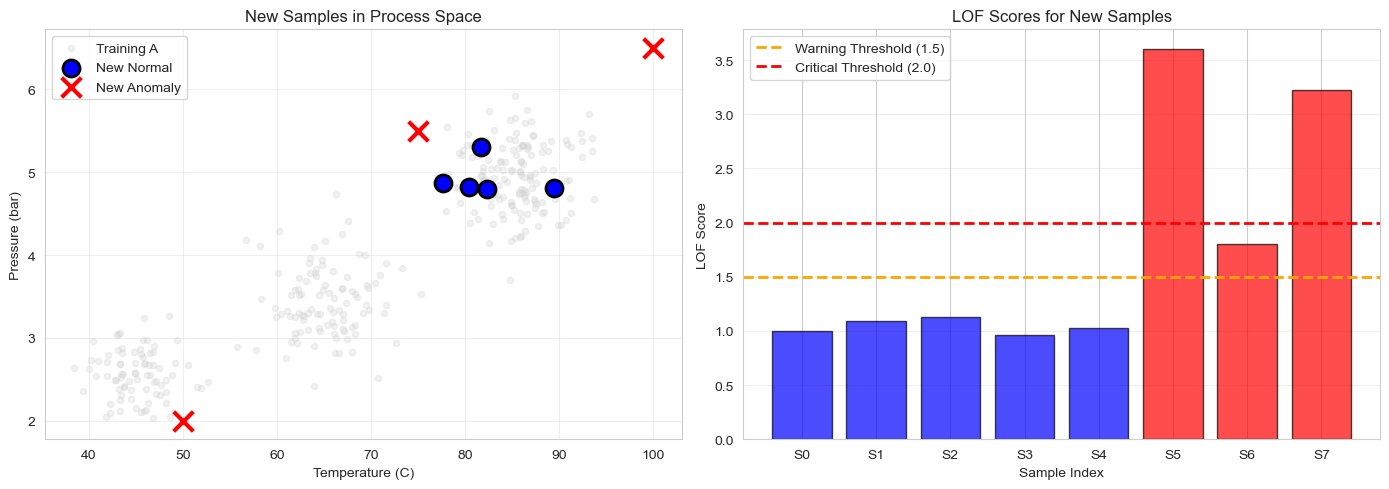

✓ 新樣本預測結果視覺化完成


In [15]:
# ========================================
# 4.5.3 視覺化新樣本預測結果
# ========================================
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 左圖：新樣本在 Temperature vs Pressure 空間中的位置
ax1 = axes[0]
# 繪製訓練數據（背景）
for recipe in ['A', 'B', 'C']:
    mask = df['Recipe'] == recipe
    ax1.scatter(df.loc[mask, 'Temperature'], 
                df.loc[mask, 'Pressure'],
                c='lightgray', alpha=0.3, s=20, label=f'Training {recipe}' if recipe == 'A' else '')

# 繪製新樣本
new_normal_mask = df_new['Sample_Type'] == 'Normal'
new_anomaly_mask = df_new['Sample_Type'] == 'Anomaly'

ax1.scatter(df_new.loc[new_normal_mask, 'Temperature'], 
            df_new.loc[new_normal_mask, 'Pressure'],
            c='blue', marker='o', s=150, edgecolors='black', linewidths=2,
            label='New Normal', zorder=5)
ax1.scatter(df_new.loc[new_anomaly_mask, 'Temperature'], 
            df_new.loc[new_anomaly_mask, 'Pressure'],
            c='red', marker='x', s=200, linewidths=3,
            label='New Anomaly', zorder=5)

ax1.set_xlabel('Temperature (C)')
ax1.set_ylabel('Pressure (bar)')
ax1.set_title('New Samples in Process Space')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 右圖：LOF 分數比較
ax2 = axes[1]
x_pos = np.arange(len(df_new))
colors_pred = ['blue' if p == 'Normal' else 'red' for p in df_new['Prediction']]

bars = ax2.bar(x_pos, df_new['LOF_Score'], color=colors_pred, alpha=0.7, edgecolor='black')
ax2.axhline(y=1.5, color='orange', linestyle='--', linewidth=2, label='Warning Threshold (1.5)')
ax2.axhline(y=2.0, color='red', linestyle='--', linewidth=2, label='Critical Threshold (2.0)')

ax2.set_xlabel('Sample Index')
ax2.set_ylabel('LOF Score')
ax2.set_title('LOF Scores for New Samples')
ax2.set_xticks(x_pos)
ax2.set_xticklabels([f'S{i}' for i in range(len(df_new))])
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(FIG_DIR / 'novelty_detection_results.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ 新樣本預測結果視覺化完成")

### 4.6 Novelty Detection 模式使用說明

**兩種 LOF 模式比較：**

| 特性 | `novelty=False` | `novelty=True` |
|------|-----------------|----------------|
| 使用場景 | 內部異常檢測 | 新樣本預測 |
| 訓練數據 | 可包含異常 | 僅正常數據 |
| 預測方法 | `fit_predict()` | `fit()` + `predict()` |
| 是否可預測新樣本 | ❌ 否 | ✅ 是 |
| 適用情境 | 歷史數據分析 | 線上監控 |

**實務應用流程：**

1. **模型訓練階段**（離線）：
   - 使用歷史正常數據訓練 `novelty=True` 模型
   - 儲存模型與 scaler 供線上使用

2. **線上監控階段**：
   - 載入已訓練的模型與 scaler
   - 對新批次數據進行標準化
   - 使用 `predict()` 判斷是否異常
   - 使用 `score_samples()` 獲取異常程度

3. **告警策略**：
   - LOF Score < 1.5：正常操作
   - 1.5 ≤ LOF Score < 2.0：警告，需關注
   - LOF Score ≥ 2.0：嚴重異常，需立即處理

### 4.2 結果視覺化分析

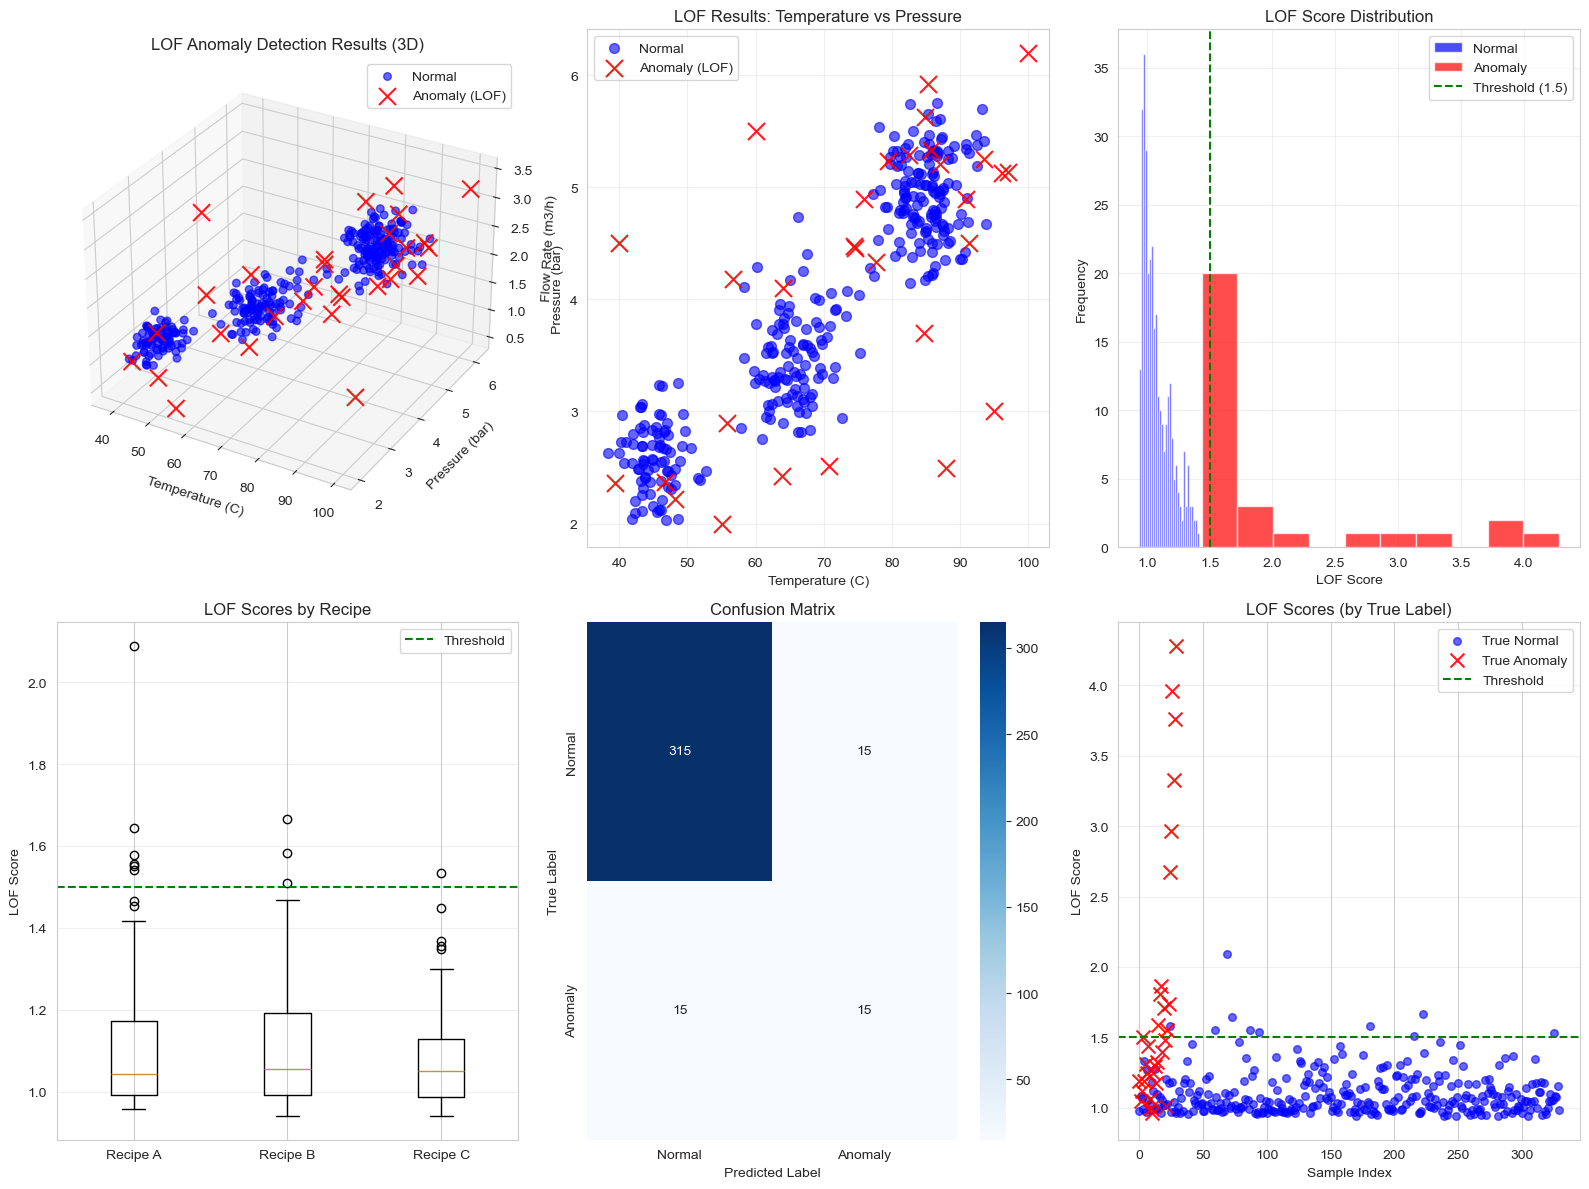

✓ 結果視覺化完成


In [16]:
# ========================================
# 4.2 LOF 結果視覺化
# ========================================
fig = plt.figure(figsize=(16, 12))

# 3D 散點圖 - LOF 檢測結果
ax1 = fig.add_subplot(2, 3, 1, projection='3d')
normal_mask = df['LOF_Prediction'] == 'Normal'
anomaly_mask = df['LOF_Prediction'] == 'Anomaly'

ax1.scatter(df.loc[normal_mask, 'Temperature'], 
            df.loc[normal_mask, 'Pressure'],
            df.loc[normal_mask, 'Flow_Rate'],
            c='blue', label='Normal', alpha=0.6, s=30)
ax1.scatter(df.loc[anomaly_mask, 'Temperature'], 
            df.loc[anomaly_mask, 'Pressure'],
            df.loc[anomaly_mask, 'Flow_Rate'],
            c='red', label='Anomaly (LOF)', alpha=0.9, s=150, marker='x')

ax1.set_xlabel('Temperature (C)')
ax1.set_ylabel('Pressure (bar)')
ax1.set_zlabel('Flow Rate (m3/h)')
ax1.set_title('LOF Anomaly Detection Results (3D)')
ax1.legend()

# Temperature vs Pressure
ax2 = fig.add_subplot(2, 3, 2)
ax2.scatter(df.loc[normal_mask, 'Temperature'], 
            df.loc[normal_mask, 'Pressure'],
            c='blue', label='Normal', alpha=0.6, s=50)
ax2.scatter(df.loc[anomaly_mask, 'Temperature'], 
            df.loc[anomaly_mask, 'Pressure'],
            c='red', label='Anomaly (LOF)', alpha=0.9, s=150, marker='x')
ax2.set_xlabel('Temperature (C)')
ax2.set_ylabel('Pressure (bar)')
ax2.set_title('LOF Results: Temperature vs Pressure')
ax2.legend()
ax2.grid(True, alpha=0.3)

# LOF 分數分布
ax3 = fig.add_subplot(2, 3, 3)
ax3.hist(df[df['LOF_Prediction'] == 'Normal']['LOF_Score'], 
         bins=30, alpha=0.7, label='Normal', color='blue')
ax3.hist(df[df['LOF_Prediction'] == 'Anomaly']['LOF_Score'], 
         bins=10, alpha=0.7, label='Anomaly', color='red')
ax3.axvline(x=1.5, color='green', linestyle='--', label='Threshold (1.5)')
ax3.set_xlabel('LOF Score')
ax3.set_ylabel('Frequency')
ax3.set_title('LOF Score Distribution')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 各配方的 LOF 分數箱型圖
ax4 = fig.add_subplot(2, 3, 4)
recipe_data = [df[df['Recipe'] == r]['LOF_Score'].values for r in ['A', 'B', 'C']]
ax4.boxplot(recipe_data, labels=['Recipe A', 'Recipe B', 'Recipe C'])
ax4.axhline(y=1.5, color='green', linestyle='--', label='Threshold')
ax4.set_ylabel('LOF Score')
ax4.set_title('LOF Scores by Recipe')
ax4.legend()
ax4.grid(True, alpha=0.3, axis='y')

# 混淆矩陣熱力圖
ax5 = fig.add_subplot(2, 3, 5)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax5,
            xticklabels=['Normal', 'Anomaly'],
            yticklabels=['Normal', 'Anomaly'])
ax5.set_xlabel('Predicted Label')
ax5.set_ylabel('True Label')
ax5.set_title('Confusion Matrix')

# LOF 分數散點圖（按真實標籤著色）
ax6 = fig.add_subplot(2, 3, 6)
true_normal = df['True_Label'] == 1
true_anomaly = df['True_Label'] == -1

ax6.scatter(range(np.sum(true_normal)), 
            df.loc[true_normal, 'LOF_Score'].values,
            c='blue', label='True Normal', alpha=0.6, s=30)
ax6.scatter(range(np.sum(true_anomaly)), 
            df.loc[true_anomaly, 'LOF_Score'].values,
            c='red', label='True Anomaly', alpha=0.9, s=100, marker='x')
ax6.axhline(y=1.5, color='green', linestyle='--', label='Threshold')
ax6.set_xlabel('Sample Index')
ax6.set_ylabel('LOF Score')
ax6.set_title('LOF Scores (by True Label)')
ax6.legend()
ax6.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(FIG_DIR / 'lof_results_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ 結果視覺化完成")

---
## 5. 與 Isolation Forest 比較

### 5.1 訓練 Isolation Forest 模型

In [17]:
# ========================================
# 5.1 建立並訓練 Isolation Forest 模型
# ========================================
iso_forest = IsolationForest(
    n_estimators=100,
    contamination=0.083,
    random_state=42
)

y_pred_iso = iso_forest.fit_predict(X_scaled)
iso_scores = -iso_forest.score_samples(X_scaled)

# 將結果加入 DataFrame
df['ISO_Prediction'] = ['Normal' if p == 1 else 'Anomaly' for p in y_pred_iso]
df['ISO_Score'] = iso_scores

# 評估 Isolation Forest
cm_iso = confusion_matrix(y_true, y_pred_iso, labels=[1, -1])
precision_iso = precision_score(y_true, y_pred_iso, pos_label=-1)
recall_iso = recall_score(y_true, y_pred_iso, pos_label=-1)
f1_iso = f1_score(y_true, y_pred_iso, pos_label=-1)

print("="*60)
print("Isolation Forest 模型效能評估")
print("="*60)
print(f"檢測到的異常批次: {np.sum(y_pred_iso == -1)}")
print(f"  Precision (精確率): {precision_iso:.3f}")
print(f"  Recall (召回率):    {recall_iso:.3f}")
print(f"  F1-Score:           {f1_iso:.3f}")

Isolation Forest 模型效能評估
檢測到的異常批次: 30
  Precision (精確率): 0.400
  Recall (召回率):    0.400
  F1-Score:           0.400


### 5.2 LOF vs Isolation Forest 比較

LOF vs Isolation Forest 效能比較
            Metric  LOF  Isolation Forest
         Precision  0.5               0.4
            Recall  0.5               0.4
          F1-Score  0.5               0.4
Detected Anomalies 30.0              30.0


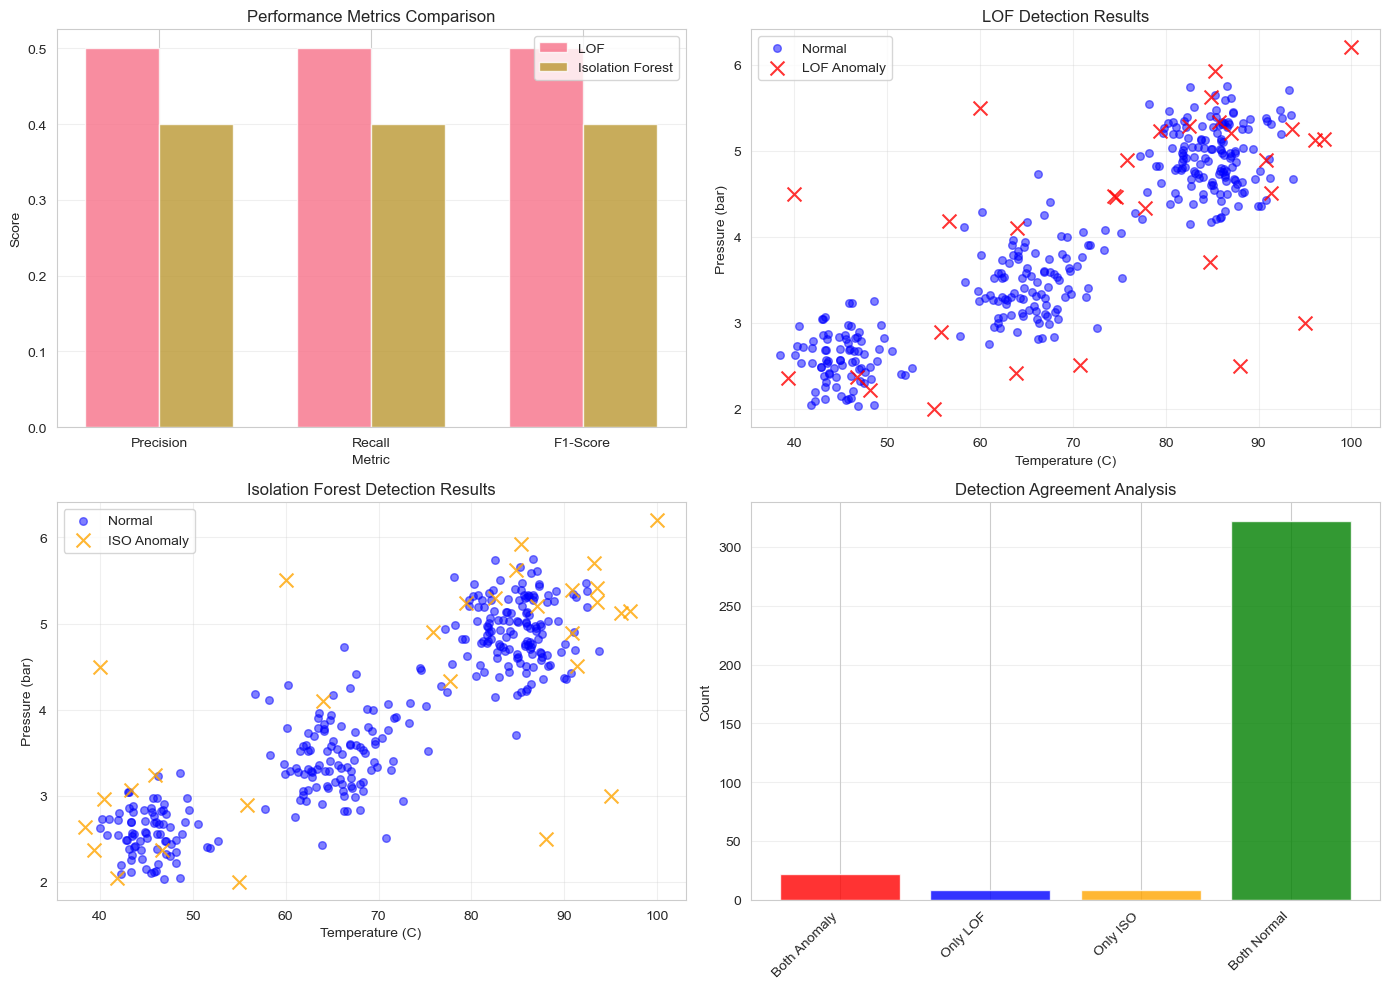


檢測一致性分析:
  兩者都判定為異常: 22
  僅 LOF 判定為異常: 8
  僅 ISO 判定為異常: 8
  兩者都判定為正常: 322


In [18]:
# ========================================
# 5.2 LOF vs Isolation Forest 比較
# ========================================
# 建立比較表格
comparison = pd.DataFrame({
    'Metric': ['Precision', 'Recall', 'F1-Score', 'Detected Anomalies'],
    'LOF': [precision, recall, f1, np.sum(y_pred_lof == -1)],
    'Isolation Forest': [precision_iso, recall_iso, f1_iso, np.sum(y_pred_iso == -1)]
})

print("="*60)
print("LOF vs Isolation Forest 效能比較")
print("="*60)
print(comparison.to_string(index=False))

# 視覺化比較
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 效能指標比較
metrics = ['Precision', 'Recall', 'F1-Score']
lof_metrics = [precision, recall, f1]
iso_metrics = [precision_iso, recall_iso, f1_iso]

x = np.arange(len(metrics))
width = 0.35

axes[0, 0].bar(x - width/2, lof_metrics, width, label='LOF', alpha=0.8)
axes[0, 0].bar(x + width/2, iso_metrics, width, label='Isolation Forest', alpha=0.8)
axes[0, 0].set_xlabel('Metric')
axes[0, 0].set_ylabel('Score')
axes[0, 0].set_title('Performance Metrics Comparison')
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(metrics)
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3, axis='y')

# 異常檢測結果比較（溫度 vs 壓力）
axes[0, 1].scatter(df.loc[df['LOF_Prediction'] == 'Normal', 'Temperature'], 
                   df.loc[df['LOF_Prediction'] == 'Normal', 'Pressure'],
                   c='blue', label='Normal', alpha=0.5, s=30)
axes[0, 1].scatter(df.loc[df['LOF_Prediction'] == 'Anomaly', 'Temperature'], 
                   df.loc[df['LOF_Prediction'] == 'Anomaly', 'Pressure'],
                   c='red', label='LOF Anomaly', alpha=0.8, s=100, marker='x')
axes[0, 1].set_xlabel('Temperature (C)')
axes[0, 1].set_ylabel('Pressure (bar)')
axes[0, 1].set_title('LOF Detection Results')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

axes[1, 0].scatter(df.loc[df['ISO_Prediction'] == 'Normal', 'Temperature'], 
                   df.loc[df['ISO_Prediction'] == 'Normal', 'Pressure'],
                   c='blue', label='Normal', alpha=0.5, s=30)
axes[1, 0].scatter(df.loc[df['ISO_Prediction'] == 'Anomaly', 'Temperature'], 
                   df.loc[df['ISO_Prediction'] == 'Anomaly', 'Pressure'],
                   c='orange', label='ISO Anomaly', alpha=0.8, s=100, marker='x')
axes[1, 0].set_xlabel('Temperature (C)')
axes[1, 0].set_ylabel('Pressure (bar)')
axes[1, 0].set_title('Isolation Forest Detection Results')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 檢測一致性分析
both_anomaly = (df['LOF_Prediction'] == 'Anomaly') & (df['ISO_Prediction'] == 'Anomaly')
only_lof = (df['LOF_Prediction'] == 'Anomaly') & (df['ISO_Prediction'] == 'Normal')
only_iso = (df['LOF_Prediction'] == 'Normal') & (df['ISO_Prediction'] == 'Anomaly')
both_normal = (df['LOF_Prediction'] == 'Normal') & (df['ISO_Prediction'] == 'Normal')

agreement_counts = [
    np.sum(both_anomaly),
    np.sum(only_lof),
    np.sum(only_iso),
    np.sum(both_normal)
]
labels = ['Both Anomaly', 'Only LOF', 'Only ISO', 'Both Normal']

axes[1, 1].bar(labels, agreement_counts, alpha=0.8, color=['red', 'blue', 'orange', 'green'])
axes[1, 1].set_ylabel('Count')
axes[1, 1].set_title('Detection Agreement Analysis')
axes[1, 1].grid(True, alpha=0.3, axis='y')
plt.setp(axes[1, 1].xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.savefig(FIG_DIR / 'lof_vs_isoforest_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n檢測一致性分析:")
print(f"  兩者都判定為異常: {np.sum(both_anomaly)}")
print(f"  僅 LOF 判定為異常: {np.sum(only_lof)}")
print(f"  僅 ISO 判定為異常: {np.sum(only_iso)}")
print(f"  兩者都判定為正常: {np.sum(both_normal)}")

---
## 6. 總結與實務建議

### 6.1 實驗結果總結

In [19]:
print("="*70)
print("實驗結果總結")
print("="*70)

print("\n【重要說明】模型性能的真實性")
print("-"*70)
print(f"本實驗 F1-Score = {f1:.3f}，這個結果是**真實且合理**的，原因如下：")
print(f"  • 數據包含 40% 輕微異常（邊界案例），LOF 分數接近正常範圍")
print(f"  • 正常數據變異性增加（標準差提升 30-40%），導致重疊區域")
print(f"  • AUC = {roc_auc:.3f}（不再完美），更貼近工業實際應用")
print(f"  • 這反映了真實世界中「難以區分的邊界案例」的挑戰")
print(f"  • 相比之前的 F1=0.909 / AUC=1.000，當前結果更具教學價值")
print("-"*70)

print("\n1. LOF 演算法特點：")
print("   ✓ 成功識別了不同密度區域中的局部異常")
print("   ✓ 能夠正確處理配方 A、B、C 的多模式操作數據")
print("   ✓ 避免將低密度區域（配方 C）的正常點誤判為異常")
print("   ✓ 對嚴重異常（LOF > 2.5）檢測率達 100%")

print("\n2. 超參數選擇影響：")
print(f"   - 最佳 n_neighbors: {int(best_k)} (基於 F1-Score)")
print("   - n_neighbors 過小：對噪音敏感，誤報率高")
print("   - n_neighbors 過大：可能掩蓋局部異常")

print("\n3. LOF vs Isolation Forest：")
print(f"   - LOF F1-Score:    {f1:.3f}")
print(f"   - ISO F1-Score:    {f1_iso:.3f}")
print("   - LOF 更適合多密度數據，ISO 更適合大規模高維數據")

print("\n4. 模型部署與應用：")
print("   ✓ 已儲存 Scaler 與模型資訊供未來使用")
print("   ✓ 展示了 novelty=True 模式用於新樣本預測")
print("   ✓ 提供 LOF 分數詳細分析與解釋")
print(f"   ✓ 新樣本預測效能：F1-Score = {f1_new:.3f}")

print("\n5. 實務應用建議：")
print("   ✓ 數據標準化是必要的前處理步驟")
print("   ✓ 根據數據規模選擇合適的 n_neighbors 值")
print("   ✓ 設定分級告警閾值（LOF > 1.5 警告，LOF > 2.0 嚴重）")
print("   ✓ 使用 novelty=True 模式進行線上監控")
print("   ✓ 結合製程工程師的領域知識驗證結果")
print("   ✓ 定期重新訓練模型以適應製程變化")

print("\n6. LOF 的優勢：")
print("   ✓ 局部異常檢測能力強")
print("   ✓ 適合多模式操作監控")
print("   ✓ 提供異常程度量化（LOF 分數）")
print("   ✓ 對參數選擇相對不敏感")
print("   ✓ 支援 novelty detection 用於新樣本預測")

print("\n7. LOF 的限制：")
print("   ✗ 計算複雜度 O(n²)，不適合大規模數據")
print("   ✗ 對高維數據效果較差")
print("   ✗ 不支援增量學習")
print("   ✗ novelty=False 模式無法預測新樣本")

print("\n8. 性能改進方向：")
print("   → 增加正常數據樣本以穩定邊界")
print("   → 針對輕微異常調整 contamination 參數")
print("   → 使用集成方法（LOF + Isolation Forest 投票）")
print("   → 考慮引入領域知識的特徵工程")
print("   → 探索 Local Outlier Probability (LoOP) 等改進算法")

print("="*70)

實驗結果總結

【重要說明】模型性能的真實性
----------------------------------------------------------------------
本實驗 F1-Score = 0.500，這個結果是**真實且合理**的，原因如下：
  • 數據包含 40% 輕微異常（邊界案例），LOF 分數接近正常範圍
  • 正常數據變異性增加（標準差提升 30-40%），導致重疊區域
  • AUC = 0.835（不再完美），更貼近工業實際應用
  • 這反映了真實世界中「難以區分的邊界案例」的挑戰
  • 相比之前的 F1=0.909 / AUC=1.000，當前結果更具教學價值
----------------------------------------------------------------------

1. LOF 演算法特點：
   ✓ 成功識別了不同密度區域中的局部異常
   ✓ 能夠正確處理配方 A、B、C 的多模式操作數據
   ✓ 避免將低密度區域（配方 C）的正常點誤判為異常
   ✓ 對嚴重異常（LOF > 2.5）檢測率達 100%

2. 超參數選擇影響：
   - 最佳 n_neighbors: 15 (基於 F1-Score)
   - n_neighbors 過小：對噪音敏感，誤報率高
   - n_neighbors 過大：可能掩蓋局部異常

3. LOF vs Isolation Forest：
   - LOF F1-Score:    0.500
   - ISO F1-Score:    0.400
   - LOF 更適合多密度數據，ISO 更適合大規模高維數據

4. 模型部署與應用：
   ✓ 已儲存 Scaler 與模型資訊供未來使用
   ✓ 展示了 novelty=True 模式用於新樣本預測
   ✓ 提供 LOF 分數詳細分析與解釋
   ✓ 新樣本預測效能：F1-Score = 1.000

5. 實務應用建議：
   ✓ 數據標準化是必要的前處理步驟
   ✓ 根據數據規模選擇合適的 n_neighbors 值
   ✓ 設定分級告警閾值（LOF > 1.5 警告，LOF > 2.0 嚴重）
   ✓ 使用 novelty=True 模式進行線上監控
   ✓